## Face detection in meme images

In [1]:
import mtcnn 
from mtcnn.mtcnn import MTCNN
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions
import PIL
from PIL import Image
import os
from urllib import request
import numpy as np
import cv2
import matplotlib.pyplot as plt

2023-03-20 09:25:29.381393: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# meme meta data
import pandas as pd

meme_df = pd.read_csv('./Data/Memes/memesfinal.csv')
meme_df['filetype'] = meme_df.url.apply(lambda x: x.split('.')[-1]); meme_df['filetype'] = meme_df['filetype'].apply(lambda x: x if len(x) <= 4 else 'jpg'); meme_df['filename'] = meme_df['id'] + '.' + meme_df['filetype']
meme_df.head()

/var/folders/nt/m5j3lfrj7zv1wxn3grk5rz3c0000gn/T/ipykernel_8072/2559025005.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  meme_df = pd.read_csv('./Data/Memes/memesfinal.csv')


,Unnamed: 0,id,title,text,score,num_comments,over18,url,date,IDURL,filetype,filename
0,612615,2021.02.15_288,Wait I didn't mean it like that,NaN,211152,1642,False,https://i.redd.it/n4ildkpurph61.png,2021-02-15,Wait I didn't mean it like thathttps://i.redd....,png,2021.02.15_288.png
1,545780,2020.10.20_959,Don't be mad,NaN,207206,811,False,https://i.redd.it/gsqgq6uwuau51.jpg,2020-10-20,Don't be madhttps://i.redd.it/gsqgq6uwuau51.jpg,jpg,2020.10.20_959.jpg
2,385925,2020.01.18_675,For real tho,NaN,207066,1734,False,https://i.redd.it/eg4t9kvlplb41.jpg,2020-01-18,For real thohttps://i.redd.it/eg4t9kvlplb41.jpg,jpg,2020.01.18_675.jpg
3,468558,2020.06.09_755,Right as rain after that,NaN,187936,743,False,https://i.redd.it/1wniz8ionv351.jpg,2020-06-09,Right as rain after thathttps://i.redd.it/1wni...,jpg,2020.06.09_755.jpg
4,485415,2020.07.08_336,Licensed Dad Joke,NaN,182056,616,False,https://i.redd.it/nrj9smsfek951.jpg,2020-07-08,Licensed Dad Jokehttps://i.redd.it/nrj9smsfek9...,jpg,2020.07.08_336.jpg


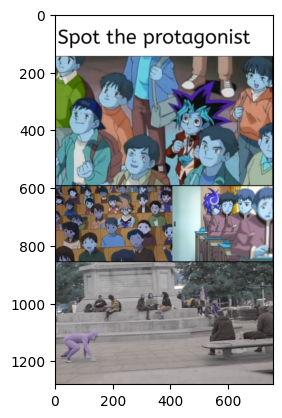

In [4]:
# access local meme images using filename from df
filename = meme_df.at[75, 'filename'] 
path_to_file = str('/Volumes/ADATA HD710 PRO/Memes2022Final2/' + filename)
img = cv2.imread(path_to_file)
plt.imshow(img)

In [5]:
# Initialize mtcnn face detector
detector = MTCNN()

2023-03-20 09:25:54.158530: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# set face extraction parameters
target_size = (224,224) # output image size
border_rel = 0 # increase or decrease zoom on image

In [7]:
# detect faces in the image
detections = detector.detect_faces(img)
print(detections)

1/1 [==============================] - 0s 189ms/step
[{'box': [241, 450, 81, 98], 'confidence': 0.9577447175979614, 'keypoints': {'left_eye': (266, 484), 'right_eye': (302, 487), 'nose': (282, 503), 'mouth_left': (266, 521), 'mouth_right': (294, 525)}}, {'box': [577, 646, 36, 43], 'confidence': 0.8489102721214294, 'keypoints': {'left_eye': (590, 662), 'right_eye': (605, 662), 'nose': (599, 670), 'mouth_left': (591, 679), 'mouth_right': (602, 680)}}]


In [8]:
# if no face is detected the length of detections is 0, otherwise length is 1
len(detections)

2

In [9]:
# get probability of face
list(detections[0].values())[1]
detections[0]['confidence']

0.9577447175979614

## Here's a function that just extracts the faces
it saves the faces into data/faces/"filename" and saves a new data column with the probability of face

In [19]:
detector = MTCNN()

def get_face(filename):
    try:
        # read in image
        path_to_file = str('/Volumes/ADATA HD710 PRO/Memes2022Final2/' + filename)
        img = cv2.imread(path_to_file)
        # detect face
        detections = detector.detect_faces(img);
        if len(detections) == 0:
            return (0,0)
        prob = detections[0]['confidence']
        if prob > 0.5:
            # extract highest prob face
            x1, y1, width, height = detections[0]['box']
            dw = round(width * border_rel)
            dh = round(height * border_rel)
            x2, y2 = x1 + width + dw, y1 + height + dh
            face = img[y1:y2, x1:x2]
            face = PIL.Image.fromarray(face)
            face = face.resize((224, 224))
            face = np.asarray(face)
            # save highest prob face stopped saving at 304000
            #im = Image.fromarray(face)
            #im.save("../data/faces/" + filename)
        return (prob, len(detections))
    except:
        return None

In [ ]:
import swifter
from io import BytesIO
from IPython import display

start = 381000

for i in range(0,1000):
    # crop dataframe
    end = start + 1000
    meme_df = meme_df[start:end]
    # get face 
    df_with_face = meme_df.filename.swifter.apply(lambda row: get_face(row) if (pd.notnull(row)) else row)
    # save data
    save = pd.DataFrame(df_with_face)
    save['id'] = meme_df['id'] 
    save.to_json('meme_faces_'+str(start)+'_'+str(end)+'.json')
    # re-load data
    meme_df = pd.read_csv('./Data/Memes/memesfinal.csv')
    meme_df['filetype'] = meme_df.url.apply(lambda x: x.split('.')[-1]); meme_df['filetype'] = meme_df['filetype'].apply(lambda x: x if len(x) <= 4 else 'jpg'); meme_df['filename'] = meme_df['id'] + '.' + meme_df['filetype']
    #meme_df['filetype'] = meme_df.url.apply(lambda x: x.split('.')[-1]); meme_df['filetype'] = meme_df['filetype'].apply(lambda x: x if len(x) <= 4 else 'jpg'); meme_df['filename'] = meme_df['id'] + '.' + meme_df['filetype']
    # update vars
    start = end
    print(start)
    display.clear_output(wait=True)
    i += 1

Pandas Apply:   0%|          | 0/1000 [00:00<?, ?it/s]

5/5 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 24ms/step


20/20 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


13/13 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 155ms/step


1/1 [==============================] - 0s 21ms/step


10/10 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 53ms/step


9/9 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 117ms/step


1/1 [==============================] - 0s 238ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 1s 507ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 286s 286s/step


1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 100ms/step


5/5 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 134ms/step


In [18]:
import pandas as pd
check1 = pd.read_json('meme_faces_384000_385000.json')
check1.tail()

,filename,id
384995,None,2021.02.24_920
384996,None,2021.07.12_906
384997,None,2022.02.26_850
384998,None,2022.02.26_944
384999,None,2019.08.17_52


In [26]:
check1 = pd.read_json('meme_faces_12.json')
#check1['face_prob'] = check1['filename'].str[0]
#check1['num_faces'] = check1['filename'].str[1]
#check1['face_binary'] = pd.Series(0, index=check1.index).mask(check1['face_prob']>0, 1)
save = check1[['id','face_prob','face_binary','num_faces']]
save.tail(20)

,id,face_prob,face_binary,num_faces
383980,2019.11.12_810,0.994732,1,2.0
383981,2019.09.16_404,0.000000,0,0.0
383982,2021.02.21_28,0.000000,0,0.0
383983,2019.09.17_115,0.000000,0,0.0
383984,2018.09.28_108,0.000000,0,0.0
383985,2019.09.07_707,0.955810,1,4.0
383986,2020.12.13_313,0.000000,0,0.0
383987,2019.10.14_973,0.000000,0,0.0
383988,2022.02.21_229,0.000000,0,0.0
383989,2019.03.29_50,0.000000,0,0.0
